加了用户数据，调了正负样本比例

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../src')
import xgboost as xgb
import pandas as pd
from features.UserJoin import UserJoin
from features.UserJoin import submit, diff, plt_month, plt_day, load_ids
import config as C
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from pathlib import Path
import sys
sys.path.append('../src')
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# data
ds = UserJoin()

In [5]:
print(ds.month.columns)
ds.month.index.max()

Index(['ym', 'pq_f', 'pq_g', 'pq_p', 'pq_z', 'pf', 'pg', 'pp', '   ',
       'ELEC_TYPE_NAME', 'VOLT_NAME', 'PRC_NAME', 'CONTRACT_CAP', 'RUN_CAP',
       'SHIFT_NO', 'BUILD_DATE', 'CANCEL_DATE', 'CHK_CYCLE', 'LAST_CHK_DATE',
       'TMP_NAME', 'TMP_DATE', 'IS_FLAG', 'label', 'p_f', 'p_g', 'f_g',
       'monthcv'],
      dtype='object')


2880712108

In [6]:
df = ds.month.copy()


idmax = df.index.max()
d = df[df.IS_FLAG == 1]
p = d[['pq_f', 'pq_p', 'pq_g', 'pq_z']] * .1

newdfs = []
for i in range(-5, 10):
    newd = d.copy()
    
    newd[['pq_f', 'pq_p', 'pq_g', 'pq_z']] = newd[['pq_f', 'pq_p', 'pq_g', 'pq_z']] + p*i
    newd = newd.reset_index()
    newd.id = newd.id + idmax*(i+6)
    newd = newd.set_index('id')

    # newt = pd.concat([df, newd])
    # newt.index.max()

    newdfs.append(newd)

t = pd.concat(newdfs + [df])
t

,ym,pq_f,pq_g,pq_p,pq_z,pf,pg,pp,,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CANCEL_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,TMP_DATE,IS_FLAG,label,p_f,p_g,f_g,monthcv
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
3210545919,2020-01-01,"2,343.500","2,342.500","2,341.500","7,027.500",0.333,0.333,0.333,"1,685.000",城镇居民生活用电,交流380V,居民合表电价(不满1千伏）,50.000,50.000,0.000,2008/10/31 8:21,0,240.000,2008/10/31,非临时用电,0,1.000,1,0.000,0.000,0.000,0.000
3210545919,2020-02-01,"1,516.500","1,532.000","1,522.000","4,570.500",0.332,0.335,0.333,"1,685.000",城镇居民生活用电,交流380V,居民合表电价(不满1千伏）,50.000,50.000,0.000,2008/10/31 8:21,0,240.000,2008/10/31,非临时用电,0,1.000,1,0.001,0.002,0.003,0.005
3210545919,2020-03-01,"2,012.500","1,961.000","2,014.000","5,987.500",0.336,0.328,0.336,"1,685.000",城镇居民生活用电,交流380V,居民合表电价(不满1千伏）,50.000,50.000,0.000,2008/10/31 8:21,0,240.000,2008/10/31,非临时用电,0,1.000,1,0.000,0.009,0.009,0.015
3210545919,2020-04-01,892.000,883.500,891.500,"2,667.000",0.334,0.331,0.334,"1,685.000",城镇居民生活用电,交流380V,居民合表电价(不满1千伏）,50.000,50.000,0.000,2008/10/31 8:21,0,240.000,2008/10/31,非临时用电,0,1.000,1,0.000,0.003,0.003,0.005
3210545919,2020-05-01,58.500,55.000,66.000,179.500,0.326,0.306,0.368,"1,685.000",城镇居民生活用电,交流380V,居民合表电价(不满1千伏）,50.000,50.000,0.000,2008/10/31 8:21,0,240.000,2008/10/31,非临时用电,0,1.000,1,0.042,0.061,0.019,0.094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880712108,2021-06-01,474.000,675.000,0.000,"1,149.000",0.413,0.587,0.000,NaN,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.000,12.000,0.000,2019/12/31 15:15,0,120.000,2019/12/31 15:15,非临时用电,0.000,NaN,test,0.413,0.587,0.175,0.905
2880712108,2021-07-01,342.000,881.000,0.000,"1,223.000",0.280,0.720,0.000,NaN,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.000,12.000,0.000,2019/12/31 15:15,0,120.000,2019/12/31 15:15,非临时用电,0.000,NaN,test,0.280,0.720,0.441,1.090
2880712108,2021-08-01,293.000,772.000,0.000,"1,065.000",0.275,0.725,0.000,NaN,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.000,12.000,0.000,2019/12/31 15:15,0,120.000,2019/12/31 15:15,非临时用电,0.000,NaN,test,0.275,0.725,0.450,1.098


In [11]:
# 把测试集 550 个之外的，都标为 0。可以标 14827个用户。虽然其中有2个实际是挖矿用户。但比例很小，应该无所谓。好处更大
testids = load_ids('35.csvbackup')
def aug1(df):
    df = df.copy()
    df.loc[df.index.isin(testids), 'IS_FLAG'] = 0
    return df


# 把挖矿用户按比例变化，1个变成10个
def aug2(df):
    idmax = df.index.max()

    d = df[df.IS_FLAG == 1]
    p = d[['pq_f', 'pq_p', 'pq_g', 'pq_z']] * .002

    newdfs = []
    for i in range(-400, 500):
        newd = d.copy()
        
        newd[['pq_f', 'pq_p', 'pq_g', 'pq_z']] = newd[['pq_f', 'pq_p', 'pq_g', 'pq_z']] + p*i
        newd = newd.reset_index()
        newd.id = newd.id + idmax*(i+6)
        newd = newd.set_index('id')

        newdfs.append(newd)

    return pd.concat(newdfs + [df])


def fix_user_month(df):
    df = df.copy()
    # 2294741747 2020 七月之前
    # 2825771263 2020 三月之前
    df.loc[(df.index == 2294741747) & (df.ym < '2020-07'), 'IS_FLAG'] = 0
    df.loc[(df.index == 2825771263) & (df.ym < '2020-03'), 'IS_FLAG'] = 0
    return df
    
    
def info(f):
    s1, s2 = diff(f, 'submit_3_7_1.csvbackup')
    s1, s2 = diff(f, 'submit_3_9_1.csvbackup')
    s1, s2 = diff(f, 'submit_3_9_2.csvbackup')
    s1, s2 = diff(f, 'submit_3_3_1.csvbackup')
    return s1 ,s2

In [12]:
month = ds.month
# month = ds.rule1(ds.month)
month = month[C.month_features + ['IS_FLAG', 'label', 'ym']]
user = ds.train[C.user_features]

user_about_month = [i for i in user.columns if i in month.columns]
monthjoin = month.join(user[user_about_month], rsuffix='_mean')

mean_cols = []
for i in monthjoin.columns:
    if 'mean' in i:
        monthjoin[i.replace('mean', 'sub_mean')] = monthjoin[i.replace('_mean', '')] - monthjoin[i]
        mean_cols.append(i)

monthjoin = monthjoin.drop(columns=mean_cols)

In [13]:
from xgboost import plot_tree
# df = monthjoin[monthjoin.index.isin(ds.train2.index.values)]
# df = month
# [['pp', 'pf', 'pg',  'monthcv', 'IS_FLAG', 'label']]
df = monthjoin
print((~df.IS_FLAG.isna()).sum())
df = fix_user_month(df)
df = aug2(df)
print(df[~df.IS_FLAG.isna()].groupby('IS_FLAG').count().ym)
features = list(set(df.columns.values) - {'IS_FLAG', 'label', 'ym'})
print(features)

xy, x_val = df.loc[~df.IS_FLAG.isna(), features+['IS_FLAG']], df.loc[df.label == 'test', features]
x, y = xy[features], xy.IS_FLAG

model = xgb.XGBClassifier(use_label_encoder=False)
                        #   learning_rate=.2,
                        #   min_child_weight=1,
                        #   subsample=.8,
                        #   colsample_bytree=.8,
                        #   seed=23)
model.fit(x, y)
y_pred = model.predict(x)
print((y_pred != y).sum())
# fig, ax = plt.subplots(figsize=(32, 16))
# plot_tree(model, ax=ax, rankdir='LR', num_trees=0)

194480
IS_FLAG
0.000    194268
1.000    191012
Name: ym, dtype: int64
['pf_sub_mean', 'pg_sub_mean', 'pq_f', 'f_g_sub_mean', 'monthcv_sub_mean', 'pf', 'p_f', 'pq_p_sub_mean', 'pq_p', 'f_g', 'p_g_sub_mean', 'p_g', 'p_f_sub_mean', 'pq_f_sub_mean', 'pq_z_sub_mean', 'pq_g_sub_mean', 'monthcv', 'pp_sub_mean', 'pq_g', 'pq_z', 'pg', 'pp']


/opt/conda/envs/miner/lib/python3.8/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[11:08:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0


In [14]:
pred = pd.DataFrame({'id': x.index.values, 'pred': y_pred.astype(int)}).groupby('id').sum()
pred = pred[pred.pred > 12]
print(pred.shape)

(9000, 1)


<AxesSubplot:>

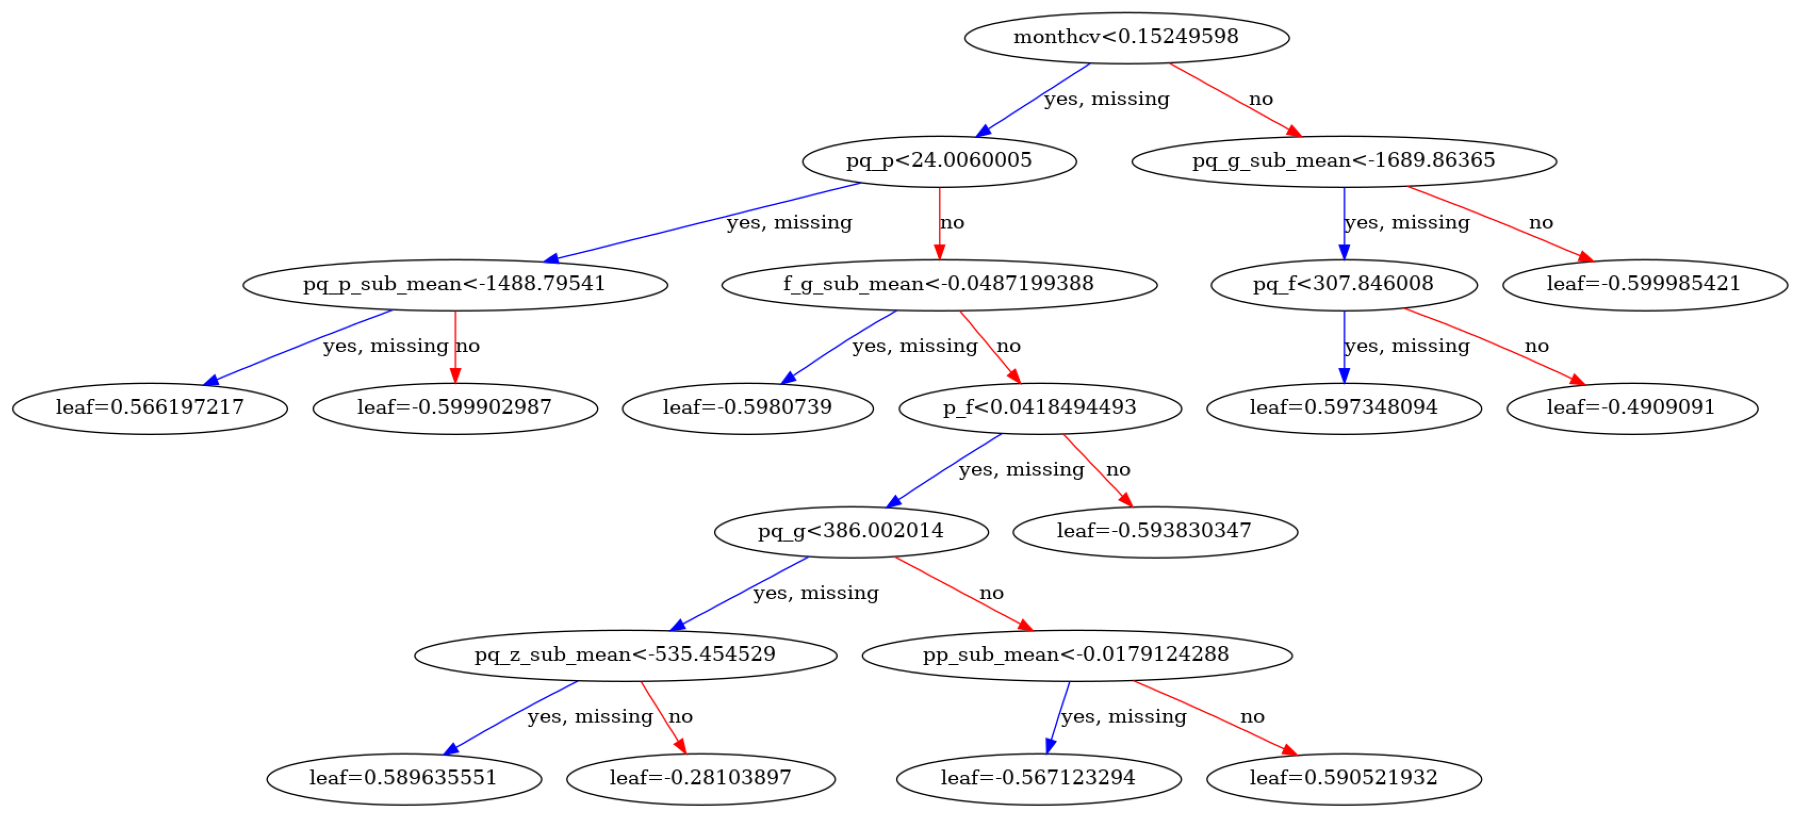

In [15]:
fig, ax = plt.subplots(figsize=(32, 16))
plot_tree(model, ax=ax)

(38, 1)


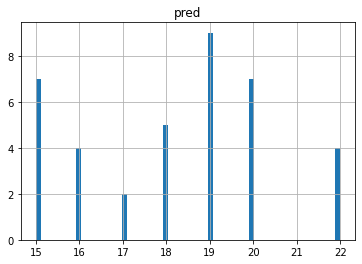

38


submit_3_7_1.csv 27
submit_3_10_1.csv 比 submit_3_7_1.csv 0.532
多了:  13
少了:  9
都有:  25



submit_3_9_1.csv 34
submit_3_10_1.csv 比 submit_3_9_1.csv 0.202
多了:  1
少了:  145
都有:  37



submit_3_9_2.csv 24
submit_3_10_1.csv 比 submit_3_9_2.csv 0.738
多了:  7
少了:  4
都有:  31



submit_3_3_1.csv 33
submit_3_10_1.csv 比 submit_3_3_1.csv 0.324
多了:  3
少了:  70
都有:  35



In [23]:
y_val = model.predict(x_val)
pred = pd.DataFrame({'id': x_val.index.values, 'pred': y_val}).groupby('id').sum()
pred = pred[pred.pred > 14]
print(pred.shape)
pred.hist(bins=60)
plt.show()

submit(pred.index.unique(), 'submit_3_10_1.csvbackup')
s1, s2 = info('submit_3_10_1.csvbackup')
# s1, s2 = info('submit_3_7_1.csv')

In [438]:
# 2294741747 2020 七月之前
# 2825771263 2020 三月之前
# plt_month(C.minerids, ds.month)
plt_month([2825771263], ds.month)
# ds.month[ds.month.index == 2294741747]

[2825771263]
